# Next Instruction Prediction Training


In [1]:
import torch

torch.cuda.is_available()

/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# DATASET GENERATION

In [2]:
#!/usr/bin/env python3

import sys,os
from elftools.elf.elffile import ELFFile
from elftools.elf.segments import Segment
from capstone import *
from capstone.x86 import *





# data_dir_path = "./data/binaries/"
# dir_file_list = os.listdir(data_dir_path)

# with open('./data/instruction_clusters.txt', 'w') as data_file:
#     for filename in dir_file_list:
#         filePath = os.path.join(data_dir_path,filename)

#         fh = open(filePath, 'rb')
#         bin_bytearray = bytearray(fh.read())
        
#         with open(filePath, 'rb') as f:
#             elf = ELFFile(f)
#             dwarfinfo = elf.get_dwarf_info()
#             aranges = dwarfinfo.get_aranges()
#             print(filename)
#             print(len(aranges.entries))
#             for arange in aranges.entries:

#                 entry = arange.begin_addr
#                 exit  = arange.begin_addr + arange.length
#                 ops = bin_bytearray[entry: exit]

#                 md = Cs(CS_ARCH_X86, CS_MODE_64)
#                 md.detail = True
#                 for inst in md.disasm(ops, entry):

#                     data_file.write(inst.mnemonic+" "+inst.op_str+";")
#                 data_file.write('\n')



# Creating the pipeline

In [3]:
from transformers import BertTokenizer, BertForNextSentencePrediction,BertForPreTraining
import torch

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained("./binary-tokenizer")
# model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')


In [4]:
data_dir_path = "./data/dissesembled_instructions/"
text = []
dir_file_list = os.listdir(data_dir_path)
for filename in dir_file_list:
    filePath = os.path.join(data_dir_path,filename)
    delim = ';'
    with open(filePath, 'r') as fp:
        text += fp.read().split('\n')


In [5]:
# text = text[:12]


In [6]:
# text[51].split(delim)

We'll assign a 50% probability of using the genuine next sentence, and 50% probability of using another random sentence.

To make this simpler, we'll create a *'bag'* of individual sentences to pull from when selecting a random sentence B.

In [7]:
bag = [instruction for instruction_cluster in text for instruction in instruction_cluster.split(delim)  if instruction!= '']
bag_size = len(bag)
print(bag_size)

54033


In [8]:
bag

['endbr64 ',
 'sub rsp, 8',
 'call 0x1270',
 'call 0x1290',
 'xor edi, edi',
 'call 0x1200',
 'xor eax, eax',
 'call 0x2720',
 'call 0x1330',
 'xor eax, eax',
 'add rsp, 8',
 'ret ',
 'nop dword ptr [rax]',
 'endbr64 ',
 'xor ebp, ebp',
 'mov r9, rdx',
 'pop rsi',
 'mov rdx, rsp',
 'and rsp, 0xfffffffffffffff0',
 'push rax',
 'push rsp',
 'xor r8d, r8d',
 'xor ecx, ecx',
 'lea rdi, [rip - 0x4f]',
 'call qword ptr [rip + 0x3c03]',
 'endbr64 ',
 'push r12',
 'lea rdx, [rip + 0x1b57]',
 'mov r12d, esi',
 'xor eax, eax',
 'push rbp',
 'mov ebp, edi',
 'lea edi, [rdi - 4]',
 'sub rsp, 8',
 'call 0x12c0',
 'lea edi, [rbp - 3]',
 'mov esi, r12d',
 'xor eax, eax',
 'lea rdx, [rip + 0x1b44]',
 'call 0x12c0',
 'lea edi, [rbp - 2]',
 'mov esi, r12d',
 'xor eax, eax',
 'lea rdx, [rip + 0x1b3f]',
 'call 0x12c0',
 'lea edi, [rbp - 1]',
 'mov esi, r12d',
 'xor eax, eax',
 'lea rdx, [rip + 0x1b3a]',
 'call 0x12c0',
 'add rsp, 8',
 'mov esi, r12d',
 'mov edi, ebp',
 'lea rdx, [rip + 0x1b30]',
 'pop rbp

And now we create our 50/50 NIP training data.

In [9]:
import random

history = []
next_instruction = []
label = []

page_len = 5
instruction_pages = []
for instruction_cluster in text:
    instructions = [
        instruction for instruction in instruction_cluster.split(delim) if instruction != ''
    ]
    if len(instructions)>page_len:
        
        for i in range(0,len(instructions),page_len):
            instruction_pages.append(instructions[i:i+page_len])
        
print(len(instruction_pages))
print(instruction_pages[0])

for instruction_page in instruction_pages:
    
#     instructions = [
#         instruction for instruction in instruction_page.split(';') if instruction != ''
#     ]
    
    
#     num_instructions = len(instruction_page)
    
    

#     start = random.randint(0, num_instructions-2)
    # 50/50 whether is IsNextSentence or NotNextSentence
    if random.random() >= 0.5:
        # this is IsNextSentence
        history.append(delim.join(instruction_page[:-1]))
        next_instruction.append(instruction_page[-1])
        label.append(0)
    else:
        index = random.randint(0, bag_size-1)
        # this is NotNextSentence
        history.append(delim.join(instruction_page[:-1]))
        next_instruction.append(bag[index])
        label.append(1)

11037
['endbr64 ', 'sub rsp, 8', 'call 0x1270', 'call 0x1290', 'xor edi, edi']


In [10]:
print(len(label))
for i in range(3):
    print(label[i])
    print('->',history[i] , '\n')
    print('# ',next_instruction[i] , '\n')

11037
0
-> endbr64 ;sub rsp, 8;call 0x1270;call 0x1290 

#  xor edi, edi 

0
-> call 0x1200;xor eax, eax;call 0x2720;call 0x1330 

#  xor eax, eax 

1
-> add rsp, 8;ret ;nop dword ptr [rax];endbr64  

#  sub eax, ecx 



Our data is now ready for tokenization, this time we truncate/pad each token to the same length of *512* tokens.

In [11]:
inputs = tokenizer(history, next_instruction, return_tensors='pt', 
                   max_length=64, truncation=True, padding='max_length')

In [12]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

We can see that the *token_type_ids* tensors have been built correctly (eg **1** indicating sentence B tokens) by checking the first instance of *token_type_ids*:

In [13]:
inputs.token_type_ids[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The **0** tokens following our sentence B tokens correspond to *PAD* tokens.

Alongside this, we need to create a *labels* tensor too - which corresponds to the values contained within our `label` variable. Our *labels* tensor must be a *LongTensor*, and we will need to transpose the tensor so that it matches our other tensors' dimensionality.

In [14]:
inputs['next_sentence_label'] = torch.LongTensor([label]).T


And the labels tensor is simply a clone of the input_ids tensor before masking.

In [15]:
inputs['labels'] = inputs.input_ids.detach().clone()

In [16]:
inputs.labels[0]

tensor([   2,  180,    1,  149,  122,    9,   19,    1,  104, 1627,   59,    1,
         104,  198,  257,    3,  233,  164,    9,  164,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

Now we mask tokens in the input_ids tensor using the 15% probability for MLM - ensuring we don't mask CLS, SEP, or PAD tokens.

In [17]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [18]:
mask_arr[0]
# inputs.input_ids.shape[0]

tensor([ True, False, False,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

And now take the indices of each True value within each vector.

In [19]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [20]:
selection[0]

[0, 3, 13, 16, 19]

Then apply these indices to each row in input_ids, assigning each value at these indices a value of 103.

In [21]:
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

In [22]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])

The `inputs` tensors are now ready, and we can begin building the model input pipeline for training. We first create a PyTorch dataset from our data.

In [23]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

Initialize our data using the `MeditationDataset` class.

In [24]:
dataset = MeditationsDataset(inputs)

In [25]:
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

And initialize the dataloader, which we'll be using to load our data into the model during training.

In [26]:
BATCH_SIZE = 8
train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
# 

Now we can move onto setting up the training loop. First we setup GPU/CPU usage.

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

Activate the training mode of our model, and initialize our optimizer (Adam with weighted decay - reduces chance of overfitting).

In [29]:
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import numpy as np


Now we can move onto the training loop, we'll train for a couple of epochs (change `epochs` to modify this).

In [30]:
# odict_keys(['loss', 'prediction_logits', 'seq_relationship_logits'])

In [31]:

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(training_data, validation_data , label ):

    font_size = 10
    x_labels = [ i for i in range(len(training_data)) ]

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, training_data , 'r') 
    plt.plot(x_labels, validation_data , 'b') 
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend(['Training', 'Validation'], loc='upper left')
    
    plt.savefig('./output/'+label+'.pdf')
    plt.show()



/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Training:   Instruction f1:  0.5369750620749217    Token f1 0.3286269384362964


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.24it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.6719319562575942    Token F1:  0.49162157521408834


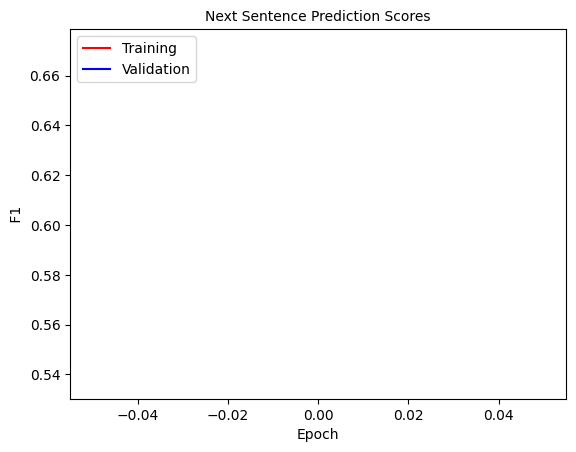

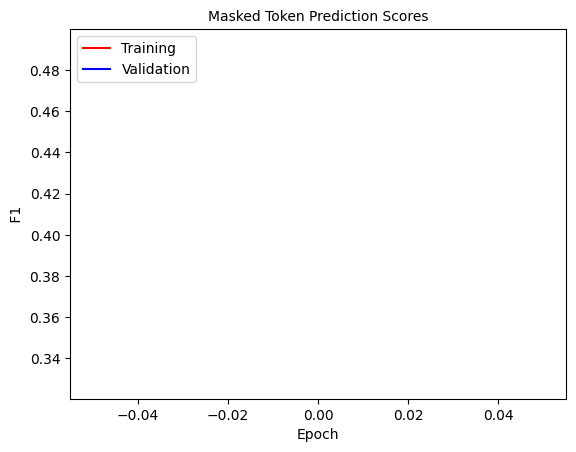

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:00<00:00,  6.12it/s, loss=1.94]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.5122689075630252    Token f1 0.5647645813516768


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.08it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.5966319165998396    Token F1:  0.668229366714072


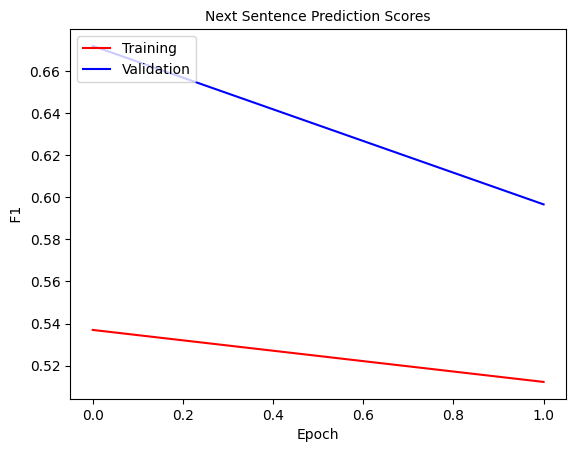

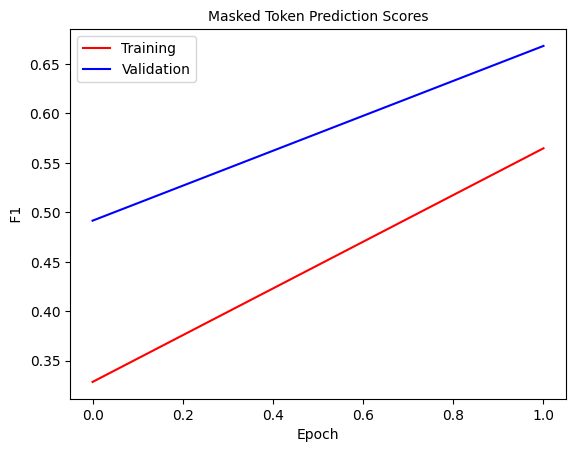

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:00<00:00,  6.12it/s, loss=1.42]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.5381570266109523    Token f1 0.7676702885544786


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.37it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.5929239528263521    Token F1:  0.8606999305806233


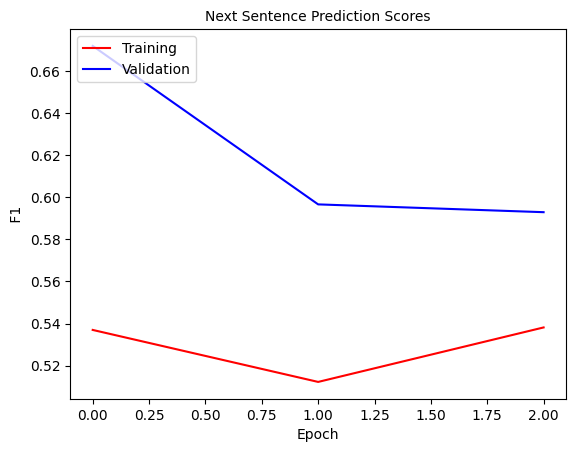

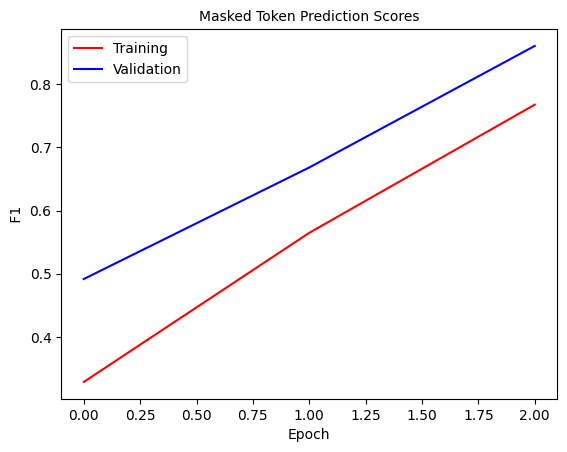

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.08it/s, loss=1.05]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.5483476132190942    Token f1 0.8794788013022526


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.22it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.686184812442818    Token F1:  0.9186002656405183


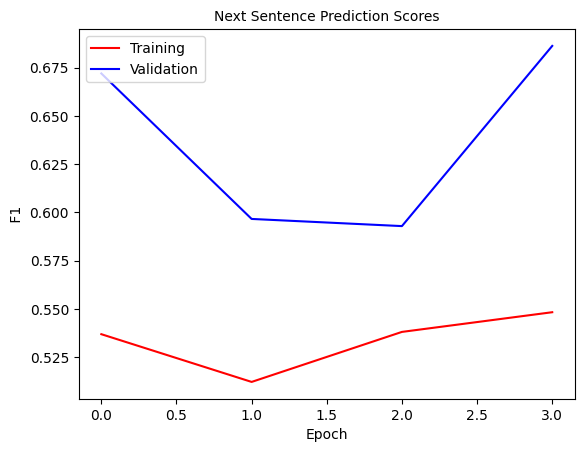

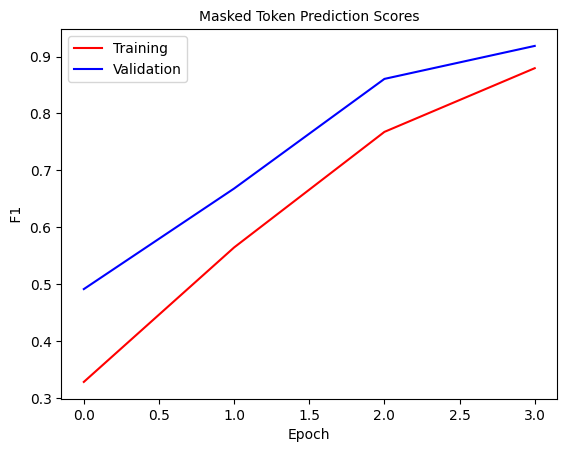

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:00<00:00,  6.11it/s, loss=0.804]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.567093194428717    Token f1 0.9159793163753464


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.14it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.4368517388651617    Token F1:  0.9353881480111768


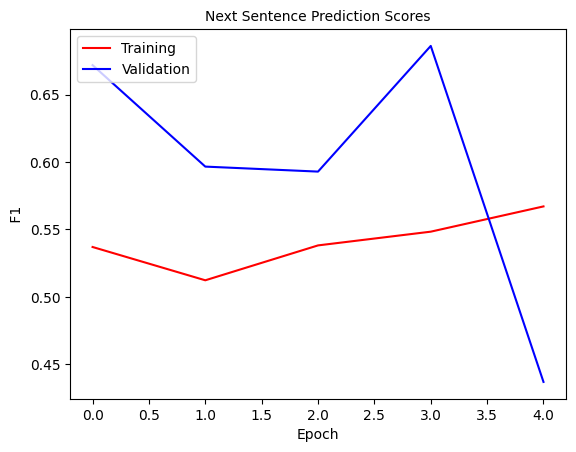

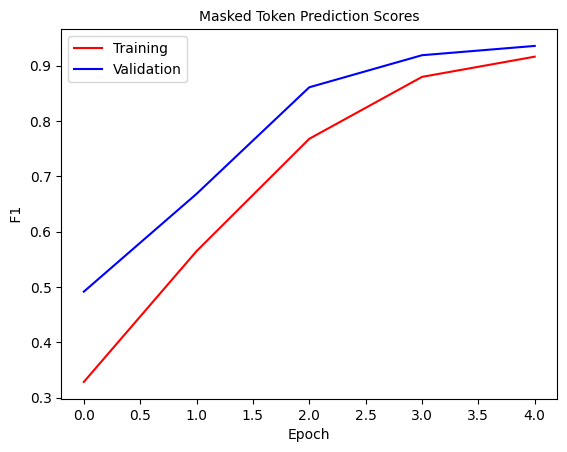

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.07it/s, loss=0.994]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.5946009115344163    Token f1 0.9295411014801858


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.93it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.6549807610089782    Token F1:  0.9474818218947995


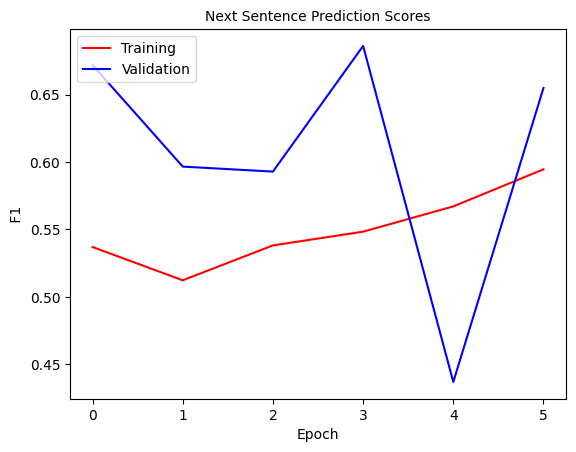

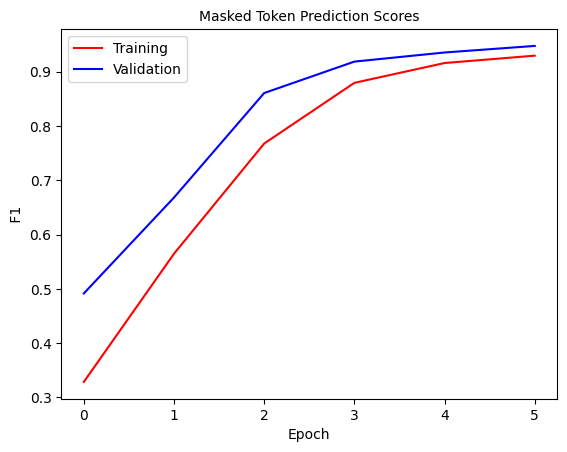

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.07it/s, loss=0.599]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.6489925768822905    Token f1 0.9380075947288435


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.10it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7024574669187146    Token F1:  0.9506995830375269


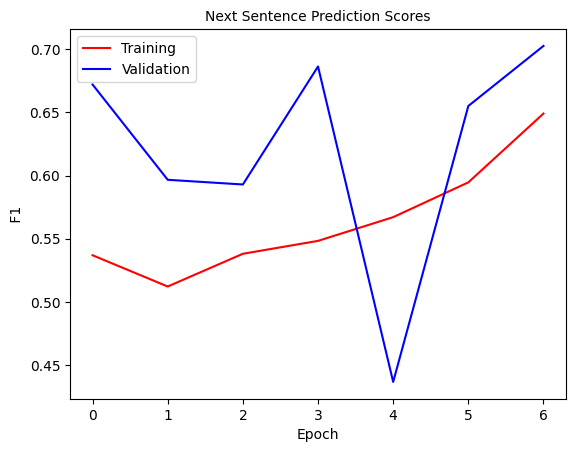

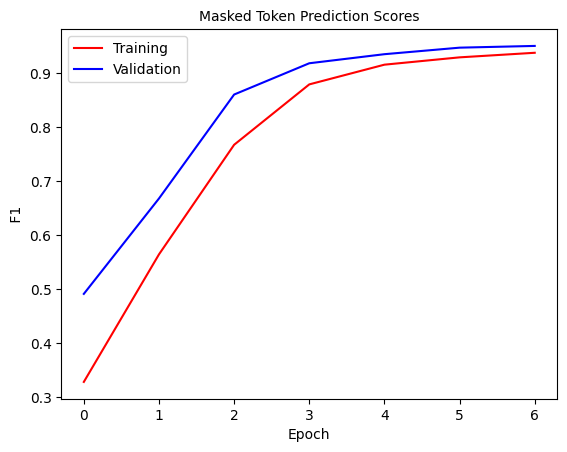

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.10it/s, loss=0.61]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.6864999407372289    Token f1 0.9425410866009857


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.17it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.702262443438914    Token F1:  0.9552447463038173


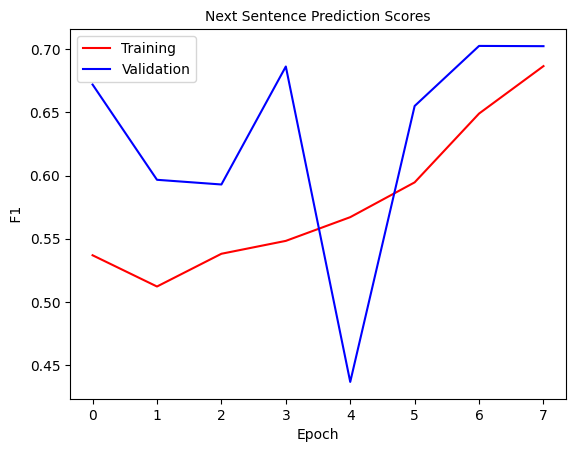

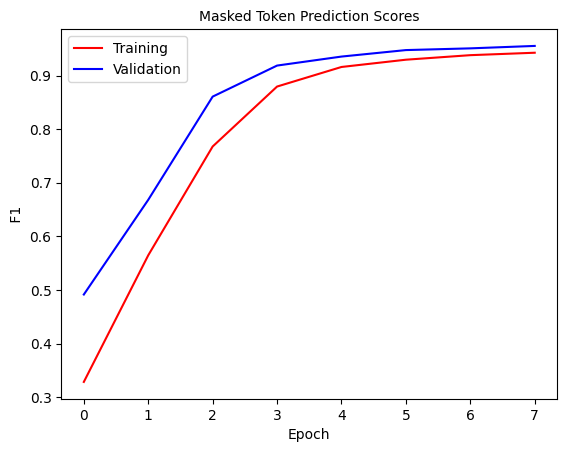

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.07it/s, loss=0.824]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.7192961876832844    Token f1 0.9457630099755482


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.03it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.6560247167868177    Token F1:  0.9572954274337194


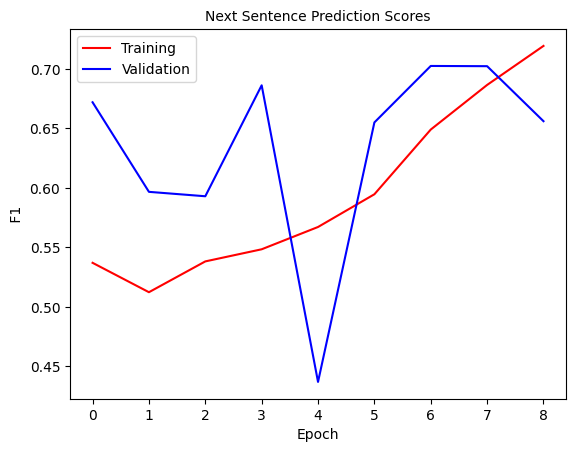

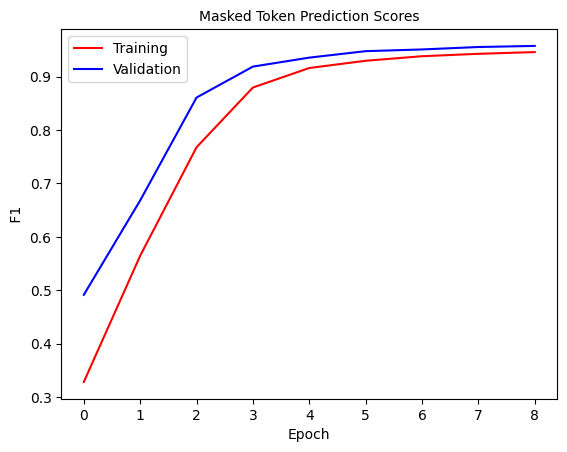

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.07it/s, loss=0.699]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.7585640544345379    Token f1 0.9485660812346673


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.05it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.725331055104656    Token F1:  0.9601645559602467


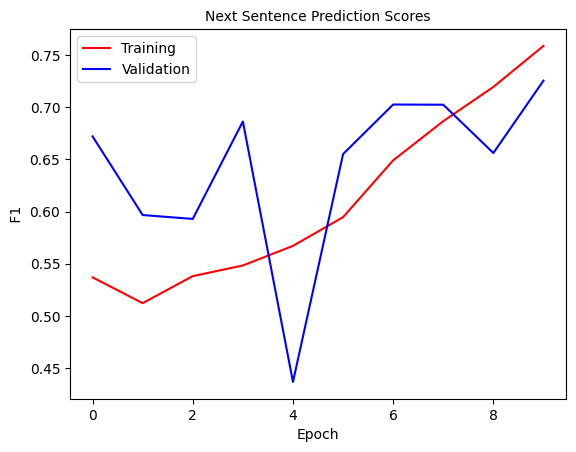

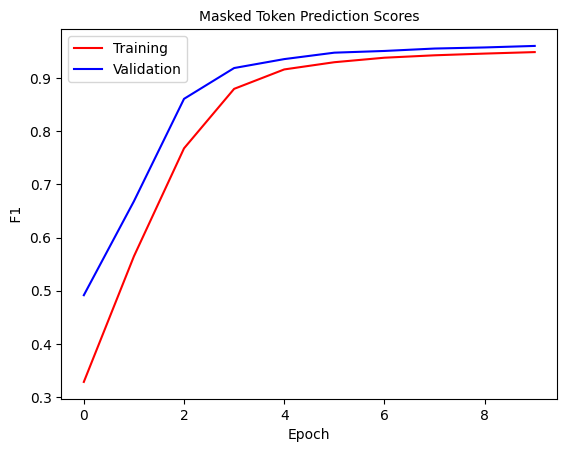

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:02<00:00,  6.05it/s, loss=0.437]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.793500806637474    Token f1 0.9503774054404729


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.98it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7265486725663718    Token F1:  0.9601422157300481


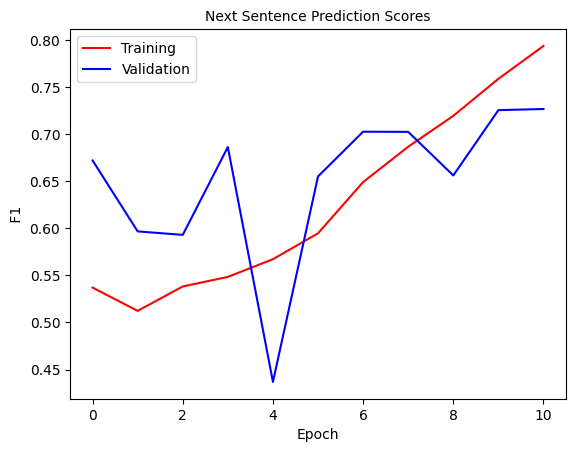

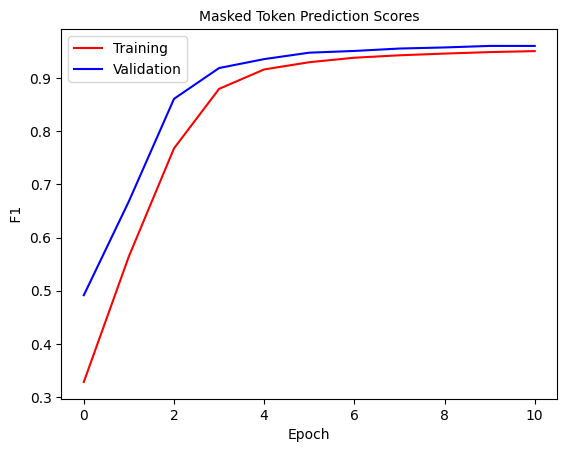

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.07it/s, loss=1.36]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.81640625    Token f1 0.9521417651251116


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.09it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7374005305039787    Token F1:  0.9620604771255814


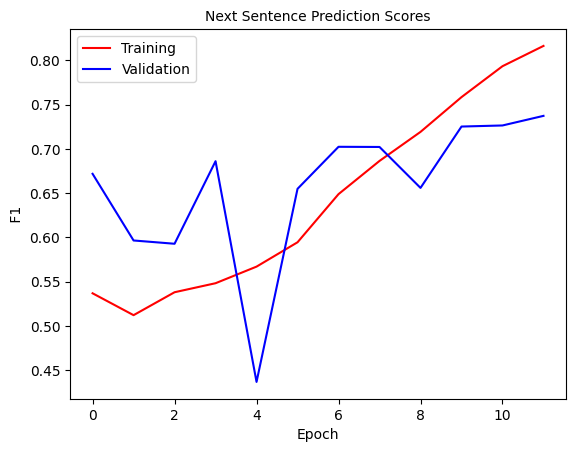

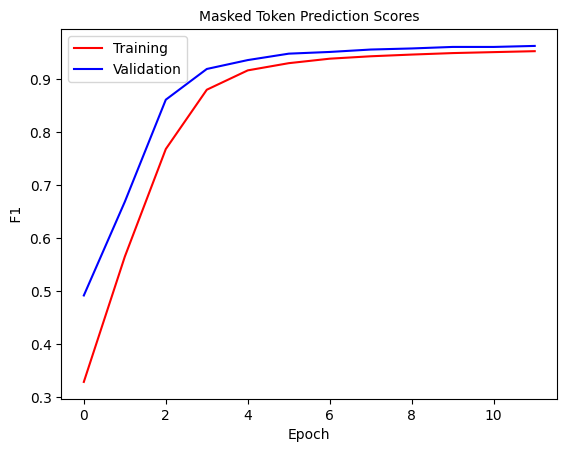

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.08it/s, loss=0.487]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.8408698653779773    Token f1 0.9536375461670001


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.05it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7599293909973522    Token F1:  0.9627161051702654


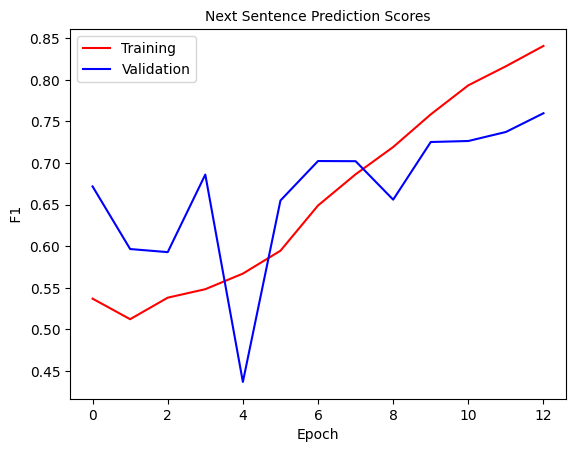

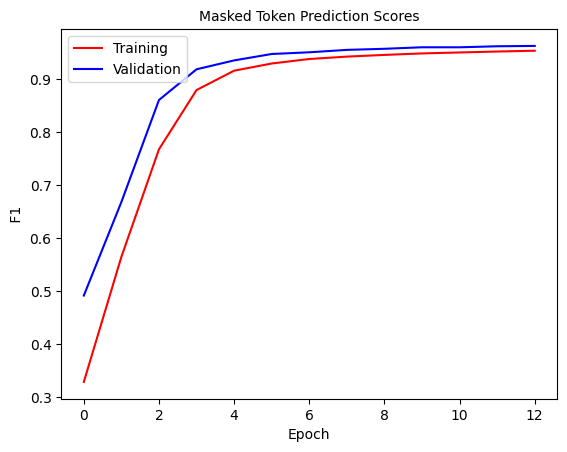

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.08it/s, loss=0.555]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.8596350281189028    Token f1 0.9547487743932345


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.04it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.747774480712166    Token F1:  0.9641236770357777


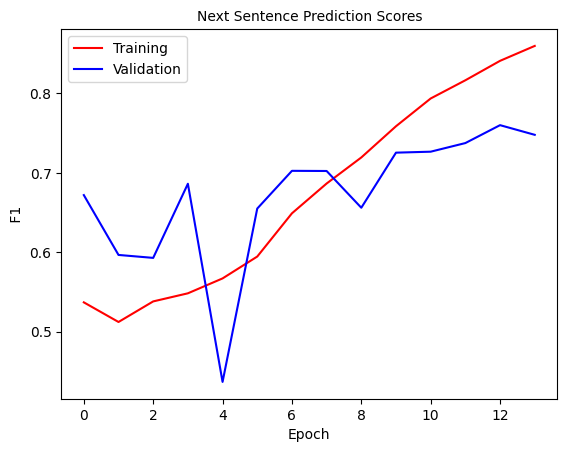

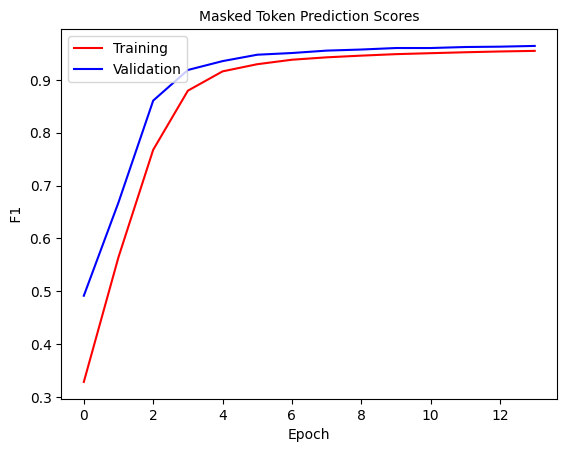

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.08it/s, loss=0.462]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.8801549327865118    Token f1 0.9564851300683123


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.05it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7539130434782608    Token F1:  0.9646311365843474


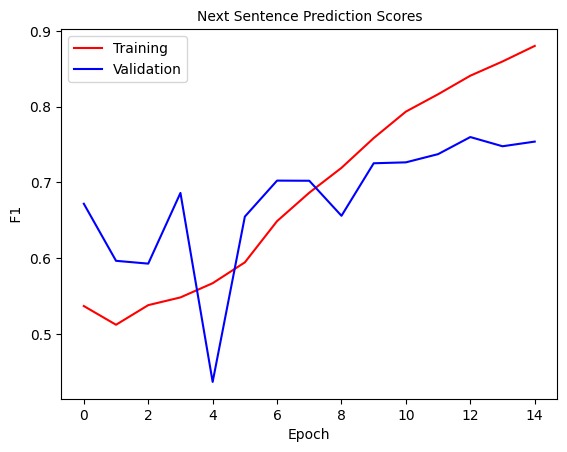

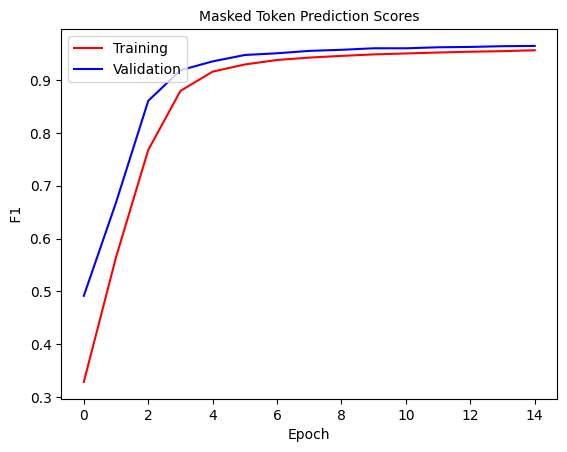

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.09it/s, loss=0.412]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.8973392714399909    Token f1 0.95744419779353


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.91it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7391705069124425    Token F1:  0.9657249648327376


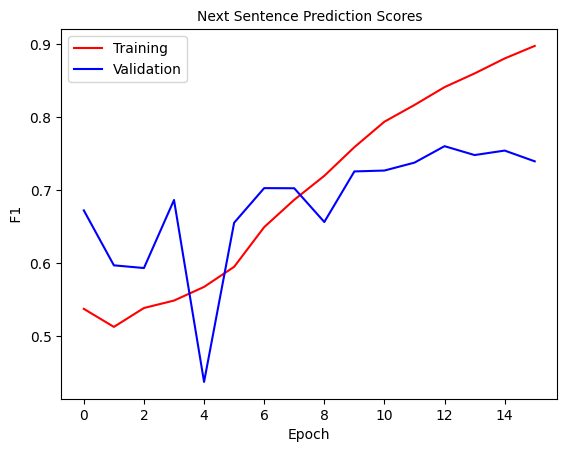

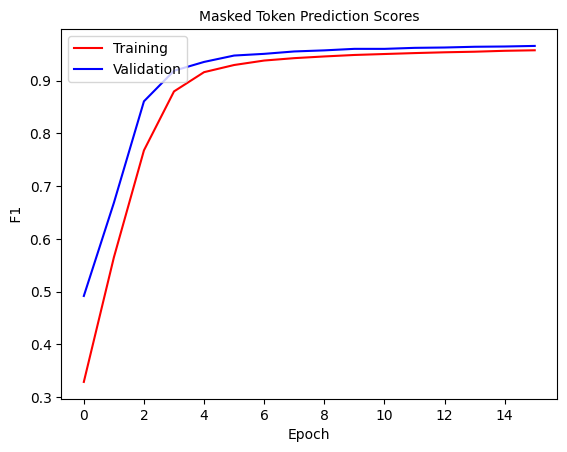

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:01<00:00,  6.09it/s, loss=0.947]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.91318254512223    Token f1 0.9580684998934396


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.33it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7561837455830389    Token F1:  0.9663982443221452


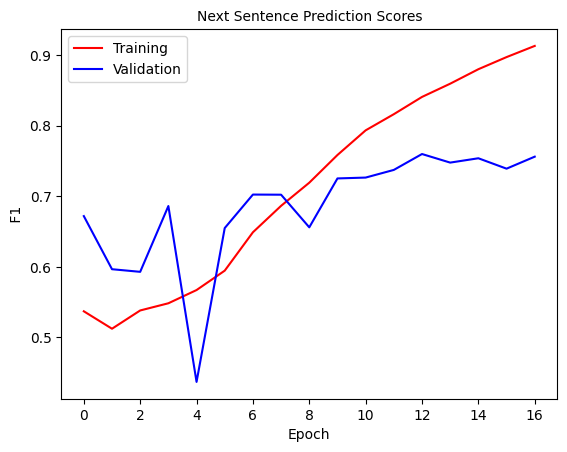

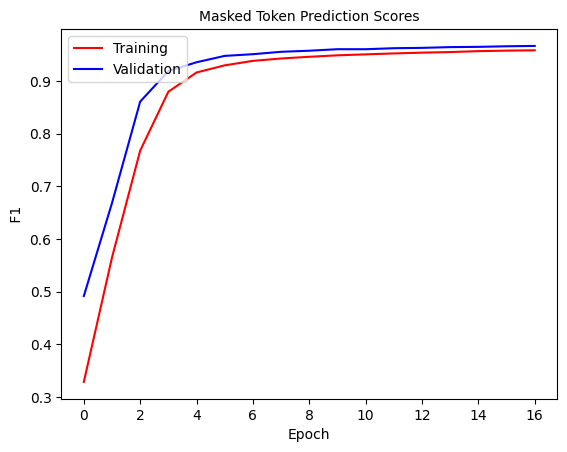

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:02<00:00,  6.05it/s, loss=0.832]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.9247752361443042    Token f1 0.9595076944532106


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.68it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7470407715914072    Token F1:  0.9670877599821546


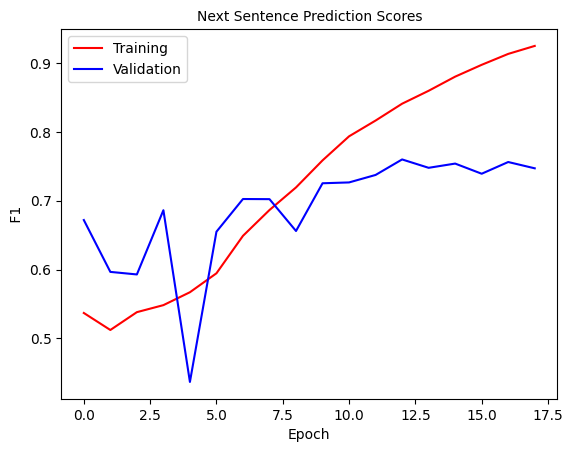

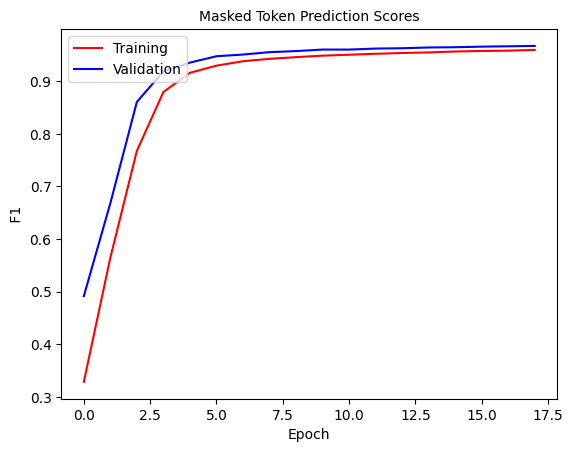

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [03:02<00:00,  6.05it/s, loss=0.172]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Training:   Instruction f1:  0.934092202618099    Token f1 0.9605192688655865


  0%|                                                                                                                                                                                      | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.10it/s]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Validation:  Instruction F1:  0.7622984704423316    Token F1:  0.968700151747226


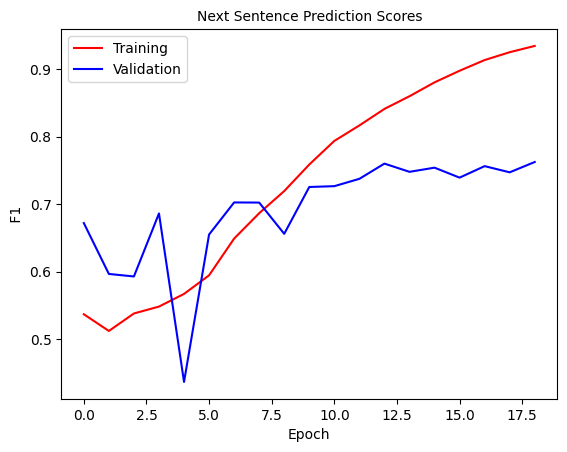

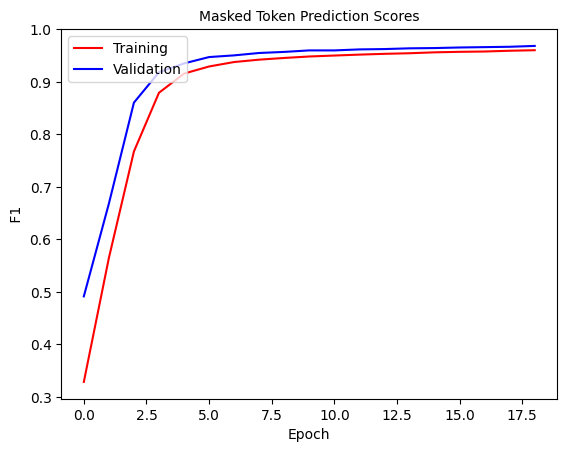

  0%|                                                                                                                                                                                     | 0/1104 [00:00<?, ?it/s]/tmp/ipykernel_117813/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 19:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 799/1104 [02:06<00:49,  6.19it/s, loss=0.368]

In [ ]:
from transformers import AdamW
from tqdm import tqdm  # for our progress bar


# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-6)



epochs = 1000000
counter = 0

global_instruction_metrices = []
global_token_metrices = []

v_global_instruction_metrices = []
v_global_token_metrices = []


for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    train_loop = tqdm(train_loader, leave=True)
    
    
    instruction_predictions_all, instruction_ground_truths_all = None, None
    token_predictions_all, token_ground_truths_all = None, None
    
    # activate training mode
    model.train()
    for N,batch in enumerate(train_loop):

        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        next_sentence_label = batch['next_sentence_label'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        next_sentence_label=next_sentence_label,
                        labels=labels)


        token_prediction = torch.argmax(outputs.prediction_logits, axis=-1)

        
        token_prediction = token_prediction.detach().cpu().numpy().flatten()
        token_ground_truth = labels.detach().cpu().numpy().flatten()
        
        
        instruction_prediction = torch.argmax(outputs.seq_relationship_logits, axis=-1)
        instruction_prediction   = instruction_prediction.detach().cpu().numpy().flatten()
        instruction_ground_truth = next_sentence_label.detach().cpu().numpy().flatten()
        
        if N==0:
            instruction_predictions_all   = instruction_prediction
            instruction_ground_truths_all = instruction_ground_truth
            
            token_predictions_all         = token_prediction
            token_ground_truths_all       = token_ground_truth  
        else:
            instruction_predictions_all   = np.concatenate((instruction_predictions_all, instruction_prediction))
            instruction_ground_truths_all = np.concatenate((instruction_ground_truths_all, instruction_ground_truth))
            token_predictions_all   = np.concatenate((token_predictions_all, token_prediction))
            token_ground_truths_all = np.concatenate((token_ground_truths_all, token_ground_truth))
            

        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        train_loop.set_description(f'Epoch {epoch}')
        train_loop.set_postfix(loss=loss.item())
    
    
    instruction_accuracy = (accuracy_score(instruction_ground_truths_all,instruction_predictions_all))
    instruction_precision, instruction_recall, instruction_f1, _ = precision_recall_fscore_support(instruction_ground_truths_all,instruction_predictions_all, average='binary')
    
    token_accuracy = (accuracy_score(token_ground_truths_all, token_predictions_all))
    token_precision, token_recall, token_f1, _ = precision_recall_fscore_support(token_ground_truths_all,token_predictions_all,average='weighted')
    
    print("Training: ",  ' Instruction f1: ', instruction_f1 , '   Token f1',token_f1)
    global_instruction_metrices.append(instruction_f1)
    global_token_metrices.append( token_f1) 

    ###########################################
    ###############  EVAL Validation  #########
    ###########################################

    with torch.no_grad():
        model.eval()
#         v_predictions_all, v_ground_truths_all = None, None
        
        v_instruction_predictions_all, v_instruction_ground_truths_all = None, None
        v_token_predictions_all, v_token_ground_truths_all = None, None
    
    
        validation_loop = tqdm(validation_loader, leave=True)
        for N,v_batch in enumerate(validation_loop):
            
            
            
            v_input_ids = v_batch['input_ids'].to(device)
            v_token_type_ids = v_batch['token_type_ids'].to(device)
            v_attention_mask = v_batch['attention_mask'].to(device)
            v_next_sentence_label = v_batch['next_sentence_label'].to(device)
            v_labels = v_batch['labels'].to(device)
            # process
            v_outputs = model(v_input_ids, attention_mask=v_attention_mask,
                            token_type_ids=v_token_type_ids,
                            next_sentence_label=v_next_sentence_label,
                            labels=v_labels)
        
            
            
            v_token_prediction = torch.argmax(v_outputs.prediction_logits, axis=-1)
            v_token_prediction = v_token_prediction.detach().cpu().numpy().flatten()
            v_token_ground_truth = v_labels.detach().cpu().numpy().flatten()
            v_instruction_prediction = torch.argmax(v_outputs.seq_relationship_logits, axis=-1)
            v_instruction_prediction   = v_instruction_prediction.detach().cpu().numpy().flatten()
            v_instruction_ground_truth = v_next_sentence_label.detach().cpu().numpy().flatten()



        

            if N==0:
                v_instruction_predictions_all   = v_instruction_prediction
                v_instruction_ground_truths_all = v_instruction_ground_truth

                v_token_predictions_all         = v_token_prediction
                v_token_ground_truths_all       = v_token_ground_truth  
            else:
                v_instruction_predictions_all   = np.concatenate((v_instruction_predictions_all, v_instruction_prediction))
                v_instruction_ground_truths_all = np.concatenate((v_instruction_ground_truths_all, v_instruction_ground_truth))
                v_token_predictions_all   = np.concatenate((v_token_predictions_all, v_token_prediction))
                v_token_ground_truths_all = np.concatenate((v_token_ground_truths_all, v_token_ground_truth))
            

        v_instruction_accuracy = (accuracy_score(v_instruction_ground_truths_all,v_instruction_predictions_all))
        v_instruction_precision, v_instruction_recall, v_instruction_f1, _ = precision_recall_fscore_support(v_instruction_ground_truths_all,v_instruction_predictions_all, average='binary')
        
        v_token_accuracy = (accuracy_score(v_token_ground_truths_all, v_token_predictions_all))
        v_token_precision, v_token_recall, v_token_f1, _ = precision_recall_fscore_support(v_token_ground_truths_all,v_token_predictions_all,average='weighted')
    
        print("Validation: ", "Instruction F1: ", v_instruction_f1,  "   Token F1: ",v_token_f1)
        
        v_global_instruction_metrices.append(v_instruction_f1)
        v_global_token_metrices.append(v_token_f1) 
#   
    
    plot_graph(global_instruction_metrices, v_global_instruction_metrices, 'Next Sentence Prediction Scores')
    plot_graph(global_token_metrices, v_global_token_metrices, 'Masked Token Prediction Scores')

In [ ]:
# # Save the trained model weights
# training_model.save_weights("weights/wghts" + str(epoch + 1) + ".ckpt")